# Introduction / Setup



In [1]:
!python3 --version

Python 3.10.12


In [2]:
# (Optional) When developing locally, this reloads the module code when changes are made,
# making it easier to iterate.
%load_ext autoreload
%autoreload 2

In [3]:
# (Required in Colab) Install the knowledge graph library from the repository.
# This will also install the dependencies.
%pip install https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip

     - 109.6 kB 6.8 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 56.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00


## Enter Environment Variables


In [5]:
# (Option 1) - Set the environment variables from getpass.
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")
os.environ["ASTRA_DB_DATABASE_ID"] = input("Enter Astra DB Database ID: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass.getpass("Enter Astra DB Application Token: ")

keyspace = input("Enter Astra DB Keyspace (Empty for default): ")
if keyspace:
    os.environ["ASTRA_DB_KEYSPACE"] = keyspace
else:
    os.environ.pop("ASTRA_DB_KEYSPACE", None)

Enter OpenAI API Key: ··········
Enter Astra DB Database ID: 956bf68d-4b5d-46be-ae16-2bc3d49f1fce
Enter Astra DB Application Token: ··········
Enter Astra DB Keyspace (Empty for default): 


In [6]:
# (Option 2) - Load the `.env` file.
# See `env.template` for an example of what you should have there.
%pip install python-dotenv
import dotenv
dotenv.load_dotenv()

False

## Initialize Astra DB / Cassandra

In [7]:
# Initialize cassandra connection from environment variables).
import cassio
cassio.init(auto=True)

ERROR:cassandra.connection:Closing connection <LibevConnection(135253351852800) 956bf68d-4b5d-46be-ae16-2bc3d49f1fce-us-east-2.db.astra.datastax.com:29042:da337f5a-b9d1-4c81-b30e-fdbfcbe049ac> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


## Create Graph Store

In [8]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

# Extracting Knowledge Graph

In [9]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [10]:
from langchain_core.documents import Document
import networkx as nx

# Generate textual summary of relationships
with open('sample.txt', 'r') as file:
    text = file.read()
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Albert Einstein', type='Person'), Node(id='Theory Of Relativity', type='Concept'), Node(id='E=Mc²', type='Concept'), Node(id='Marie Curie', type='Person'), Node(id='Radioactivity', type='Concept'), Node(id='Nobel Prize', type='Concept'), Node(id='Martin Luther King Jr.', type='Person'), Node(id='Nonviolent Resistance', type='Concept'), Node(id='I Have A Dream', type='Speech'), Node(id='Mahatma Gandhi', type='Person'), Node(id='Nonviolent Civil Disobedience', type='Concept'), Node(id='Nelson Mandela', type='Person'), Node(id='Apartheid', type='Concept'), Node(id='Frida Kahlo', type='Person'), Node(id='Self-Portraits', type='Art'), Node(id='Steve Jobs', type='Person'), Node(id='Apple Inc.', type='Organization'), Node(id='Macintosh', type='Product'), Node(id='Ipod', type='Product'), Node(id='Iphone', type='Product'), Node(id='Ipad', type='Product'), Node(id='Malala Yousafzai', type='Person'), Node(id='Education Activism', type='Concept'), Node(id='I Am Malala', type='Book'

In [11]:
# Save the extracted graph documents to the AstraDB / Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

In [12]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

# Test Knowledge Graph Query

In [14]:
chain.invoke("Who is Albert Einstein?")

AIMessage(content='Albert Einstein is a person who developed the Theory of Relativity and the concept of E=Mc².', response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 90, 'total_tokens': 111}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-403f6855-6958-4a30-aa13-62acaf34c136-0')

#Check Graph Status

In [15]:
# Print the nodes and relationships to verify correctness
for doc in graph_documents:
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")
    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source}, Target: {relationship.target}, Type: {relationship.type}")


Nodes:
ID: Albert Einstein, Type: Person
ID: Theory Of Relativity, Type: Concept
ID: E=Mc², Type: Concept
ID: Marie Curie, Type: Person
ID: Radioactivity, Type: Concept
ID: Nobel Prize, Type: Concept
ID: Martin Luther King Jr., Type: Person
ID: Nonviolent Resistance, Type: Concept
ID: I Have A Dream, Type: Speech
ID: Mahatma Gandhi, Type: Person
ID: Nonviolent Civil Disobedience, Type: Concept
ID: Nelson Mandela, Type: Person
ID: Apartheid, Type: Concept
ID: Frida Kahlo, Type: Person
ID: Self-Portraits, Type: Art
ID: Steve Jobs, Type: Person
ID: Apple Inc., Type: Organization
ID: Macintosh, Type: Product
ID: Ipod, Type: Product
ID: Iphone, Type: Product
ID: Ipad, Type: Product
ID: Malala Yousafzai, Type: Person
ID: Education Activism, Type: Concept
ID: I Am Malala, Type: Book
ID: Malala Fund, Type: Organization
ID: Leonardo Da Vinci, Type: Person
ID: The Last Supper, Type: Art
ID: Mona Lisa, Type: Art
ID: Oprah Winfrey, Type: Person
ID: The Oprah Winfrey Show, Type: Tv_show

Relationsh

#Draw Graph

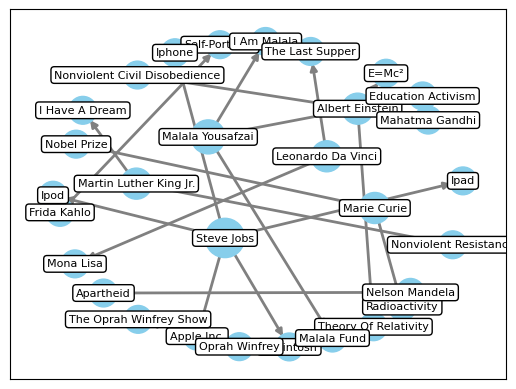

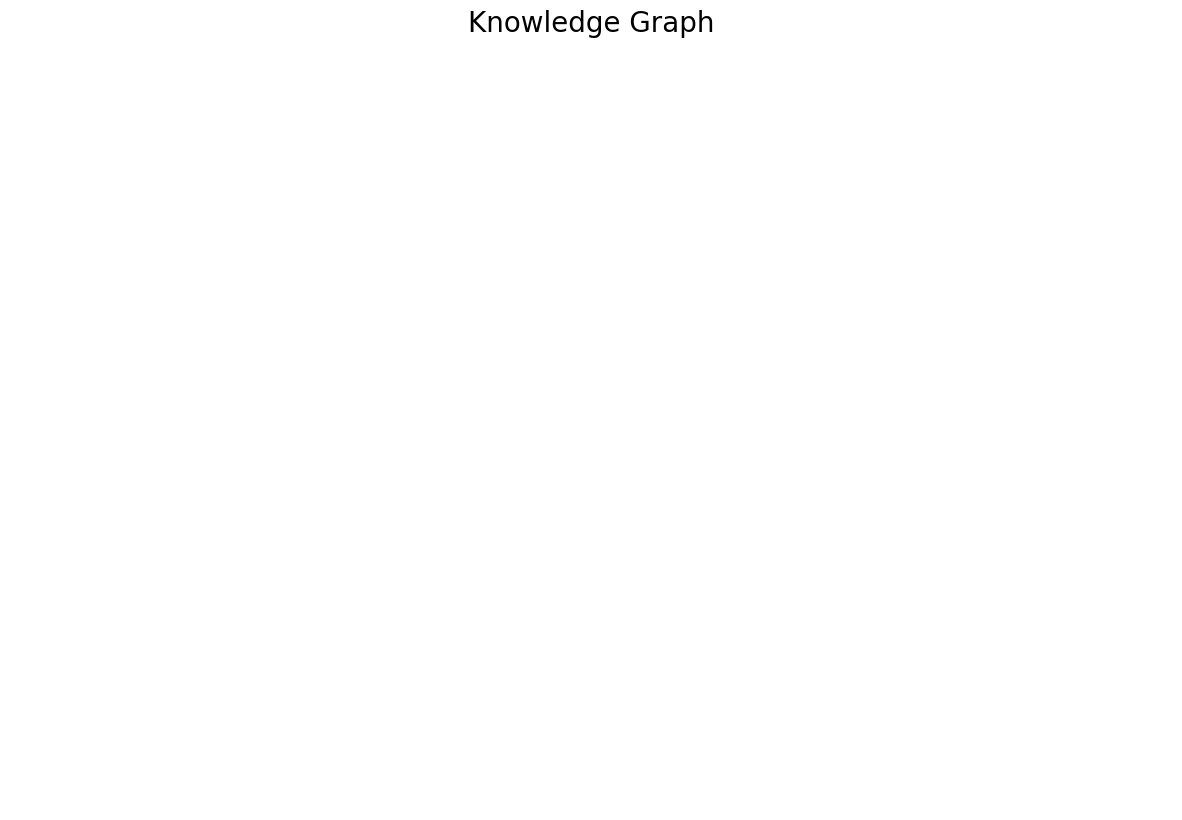

In [21]:
import matplotlib.pyplot as plt

def visualize_graph(graph_documents):
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    # Identify all nodes that are sources of relationships
    source_nodes = set(relationship.source.id for doc in graph_documents for relationship in doc.relationships)

    # Get positions for the nodes
    pos = nx.spring_layout(G, k=5, iterations=200, center=(0.5, 0.5))  # Increase k value for more spacing

    # Nodes with sizes based on their degree, reduced size
    node_sizes = [300 + 100 * G.degree(node) for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

    # Ensure every node has a label, defaulting to the node ID
    node_labels = {node: G.nodes[node].get('label', node) for node in G.nodes}

    # Node labels with increased font size and padding
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif',
                            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')

    # Edge labels with increased font size
    #edge_labels = nx.get_edge_attributes(G, 'label')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5, font_color='black')

    plt.figure(figsize=(15, 10))  # Increase figure size
    plt.title("Knowledge Graph", fontsize=20)
    plt.axis('off')  # Hide axis
    plt.show()
visualize_graph(graph_documents)

# Transport Knowledge Graph to Pytorch Geometric Graph

In [23]:
# Custom Data class to include num_classes and num_features
from torch_geometric.data import Data
class CustomData(Data):
    def __init__(self, num_classes=None, num_features=None, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_features = num_features

    @classmethod
    def from_data(cls, data, num_classes=None, num_features=None):
        obj = cls(num_classes=num_classes, num_features=num_features, **data.to_dict())
        return obj

In [35]:
import torch
from community import community_louvain
def convert_to_pyg_data(graph_documents, num_features, num_classes):
    nodes = []
    edges = []

    # Extract nodes and edges from the graph documents
    node_id_map = {}
    for doc in graph_documents:
        for idx, node in enumerate(doc.nodes):
            if node.id not in node_id_map:
                node_id_map[node.id] = len(node_id_map)
                nodes.append(node.id)
        for relationship in doc.relationships:
            source_id = node_id_map[relationship.source.id]
            target_id = node_id_map[relationship.target.id]
            edges.append((source_id, target_id))

    # Convert nodes and edges to PyTorch tensors
    num_nodes = len(node_id_map)
    x = torch.eye(num_nodes, num_features)  # Identity matrix as dummy node features
    y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)  # Random labels for demonstration

    return CustomData(x=x, edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(), y=y,
                      num_classes=num_classes, num_features=num_features)

def get_graph_stats(graph_documents):
    G = nx.Graph()

    # Extract nodes and edges from the graph documents to create a networkx graph
    for doc in graph_documents:
        for node in doc.nodes:
            G.add_node(node.id)
        for relationship in doc.relationships:
            G.add_edge(relationship.source.id, relationship.target.id)

    num_features = G.number_of_nodes()

    # Use community detection to find the number of clusters
    partition = community_louvain.best_partition(G)
    num_classes = len(set(partition.values()))

    return num_classes, num_features

# Display Graph

Number of classes: 10
Number of features: 30


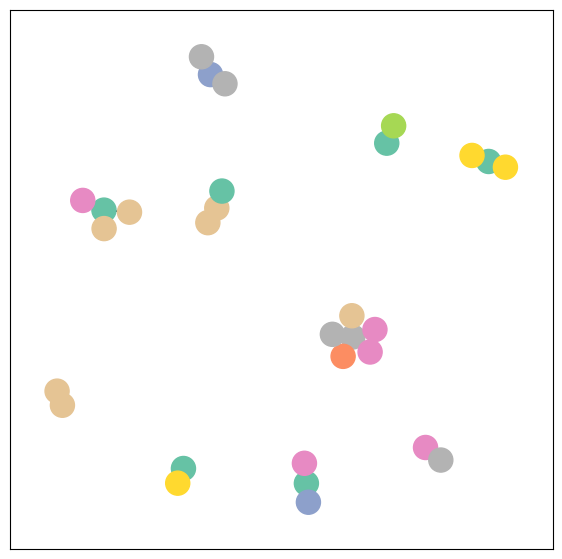

In [36]:
from torch_geometric.utils import to_networkx
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
num_classes, num_features = get_graph_stats(graph_documents)
print(f'Number of classes: {num_classes}')
print(f'Number of features: {num_features}')
data = convert_to_pyg_data(graph_documents,num_features,num_classes)
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Setup Graph Neural Network

In [59]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, data.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h


Embedding shape: [30, 2]


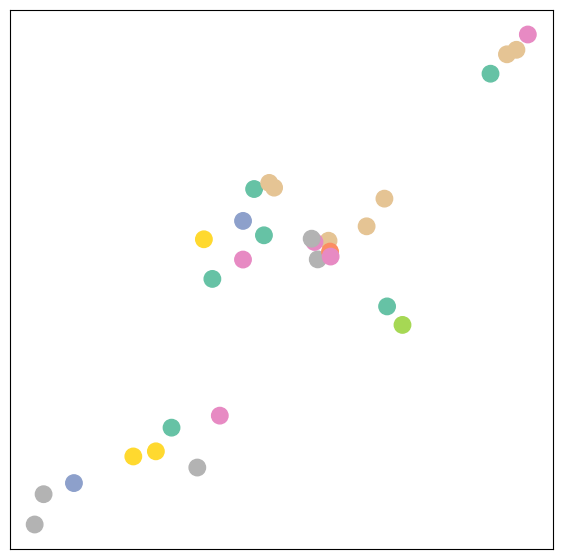

In [60]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [61]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
# Define accuracy calculation function
def accuracy(pred_y, y):
    return (pred_y == y).sum().item() / y.size(0)

# Setup
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss based on all nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out

<IPython.core.display.Javascript object>

# Train Graph Neural Network

Epoch: 0, Loss: 0.7483, Accuracy: 0.7000


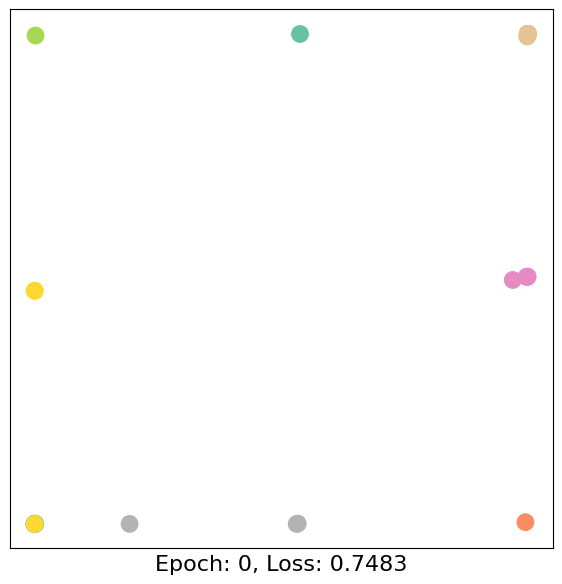

Epoch: 10, Loss: 0.7477, Accuracy: 0.7000


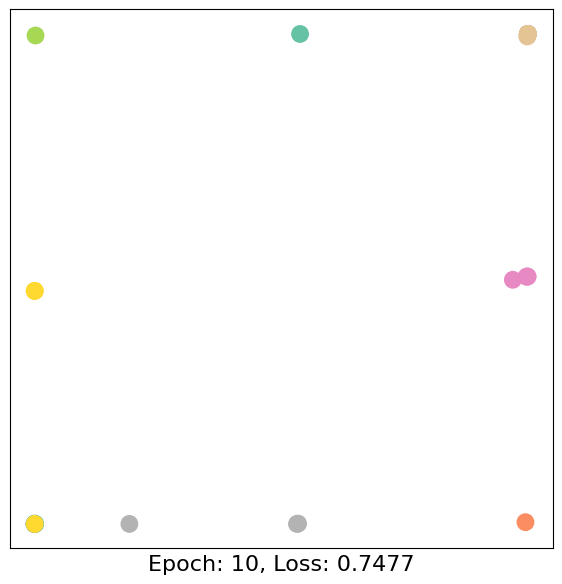

Epoch: 20, Loss: 0.7471, Accuracy: 0.7000


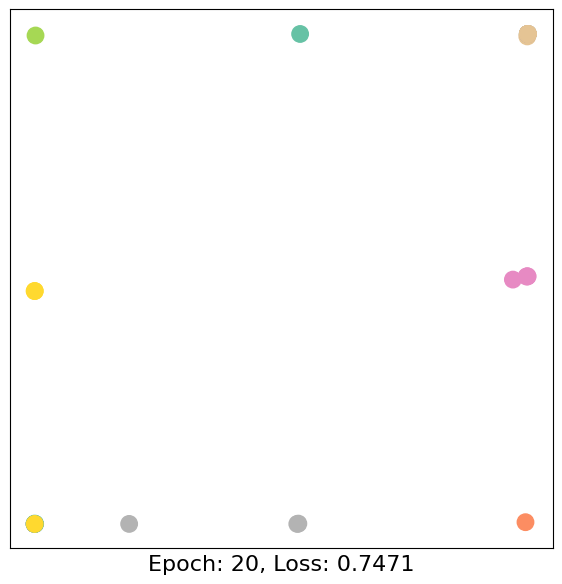

Epoch: 30, Loss: 0.7466, Accuracy: 0.7000


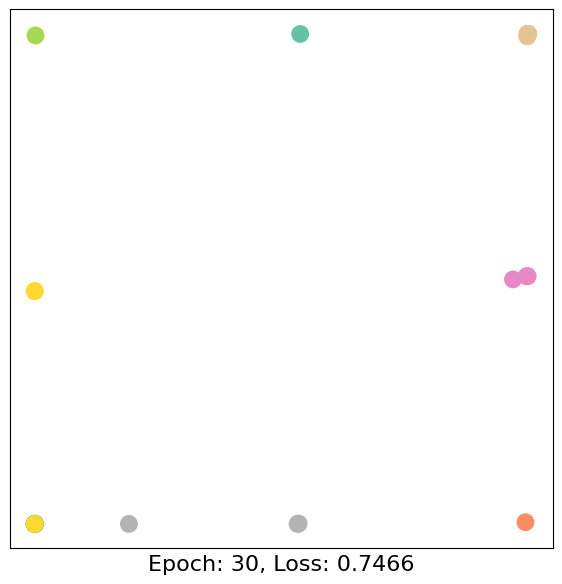

Epoch: 40, Loss: 0.7460, Accuracy: 0.7000


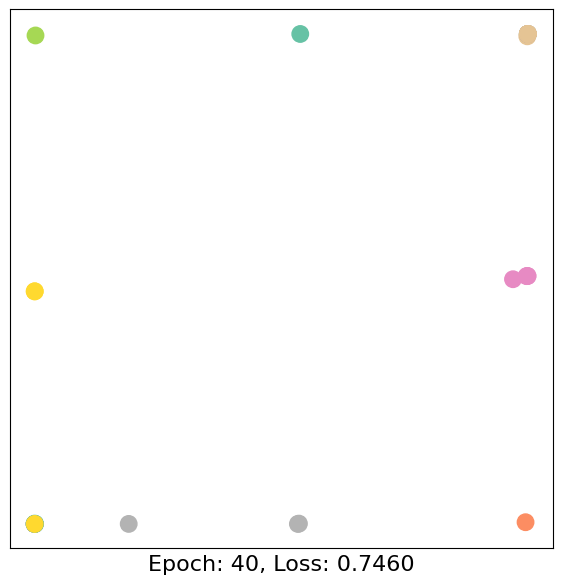

Epoch: 50, Loss: 0.7455, Accuracy: 0.7000


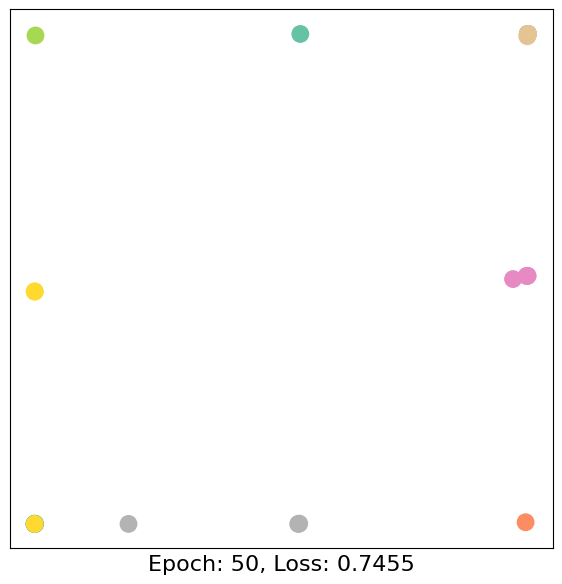

Epoch: 60, Loss: 0.7449, Accuracy: 0.7000


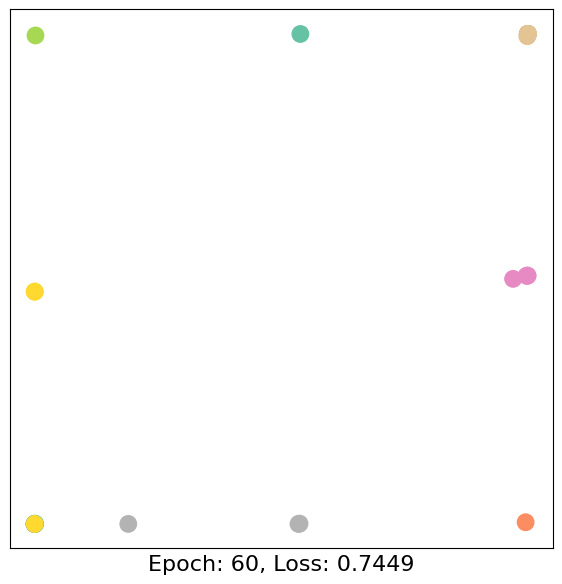

Epoch: 70, Loss: 0.7444, Accuracy: 0.7000


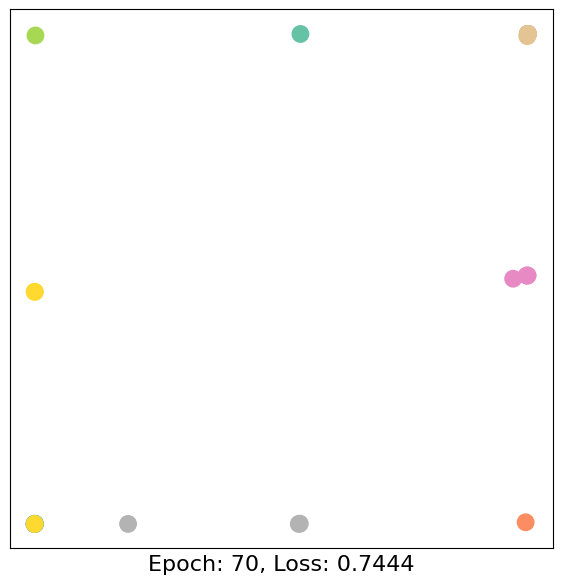

Epoch: 80, Loss: 0.7439, Accuracy: 0.7000


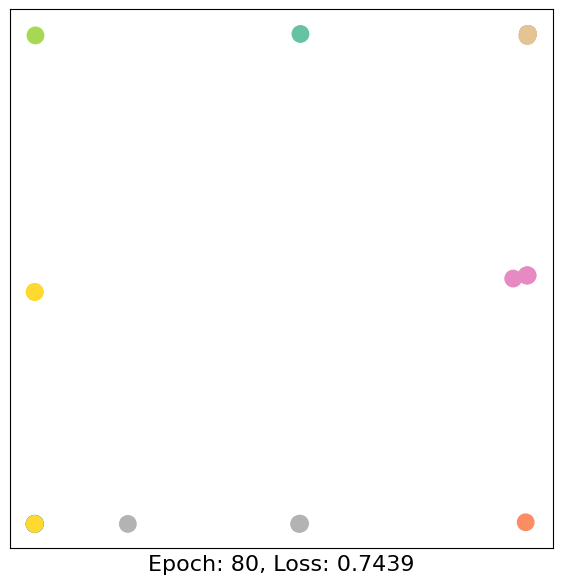

Epoch: 90, Loss: 0.7434, Accuracy: 0.7000


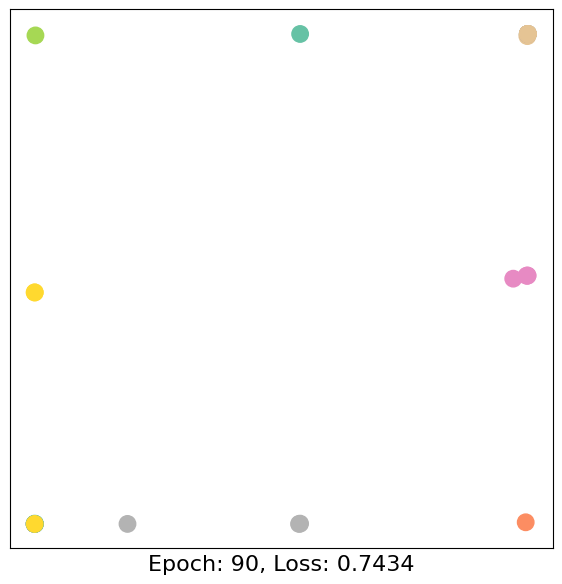

Epoch: 100, Loss: 0.7431, Accuracy: 0.7000


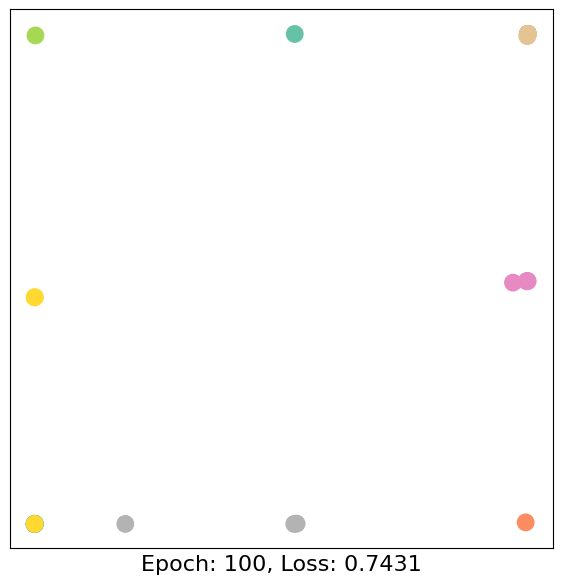

Epoch: 110, Loss: 0.8306, Accuracy: 0.7333


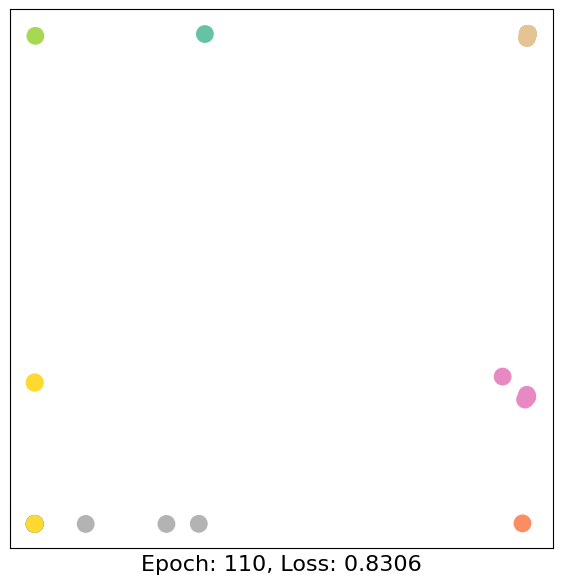

Epoch: 120, Loss: 0.7472, Accuracy: 0.7000


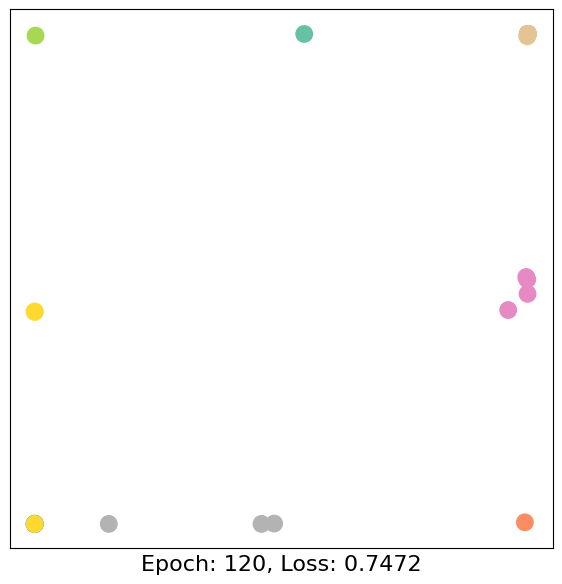

Epoch: 130, Loss: 0.7541, Accuracy: 0.7000


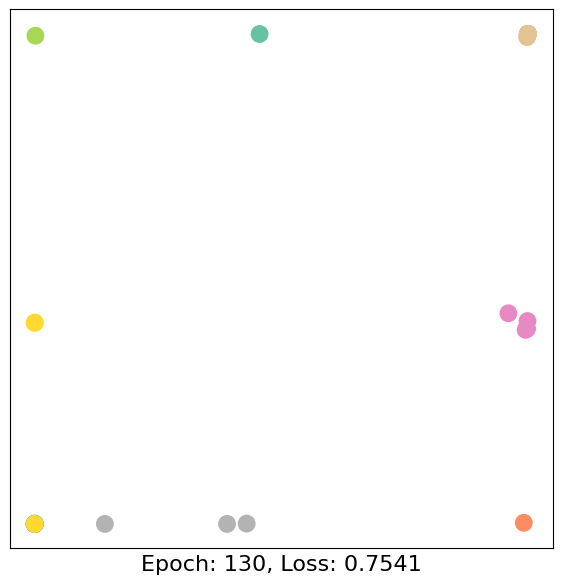

Epoch: 140, Loss: 0.7452, Accuracy: 0.7000


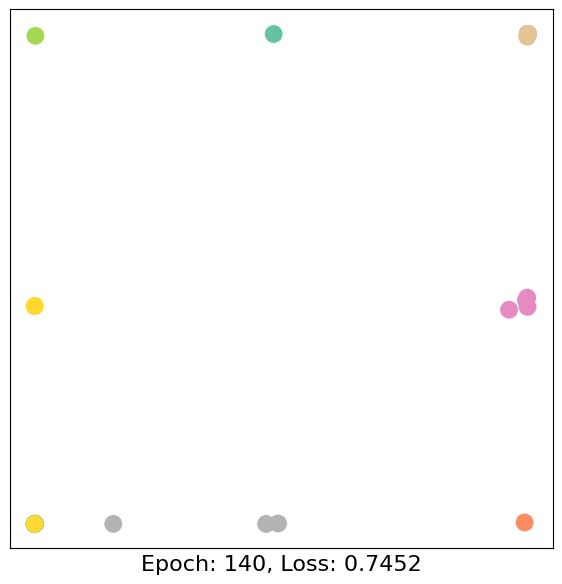

Epoch: 150, Loss: 0.7420, Accuracy: 0.7000


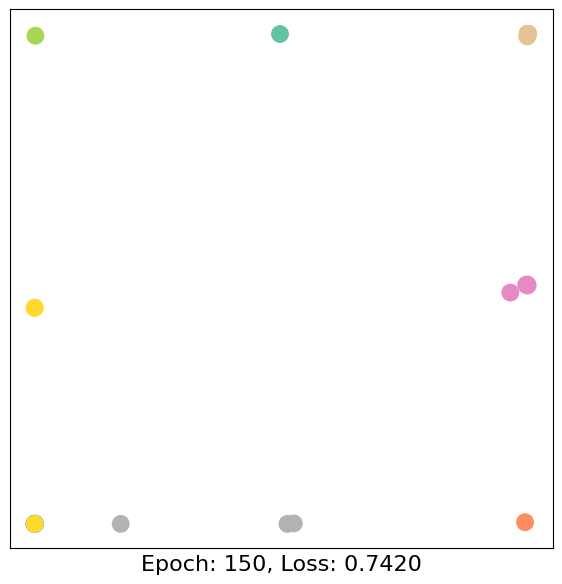

Epoch: 160, Loss: 0.7404, Accuracy: 0.7000


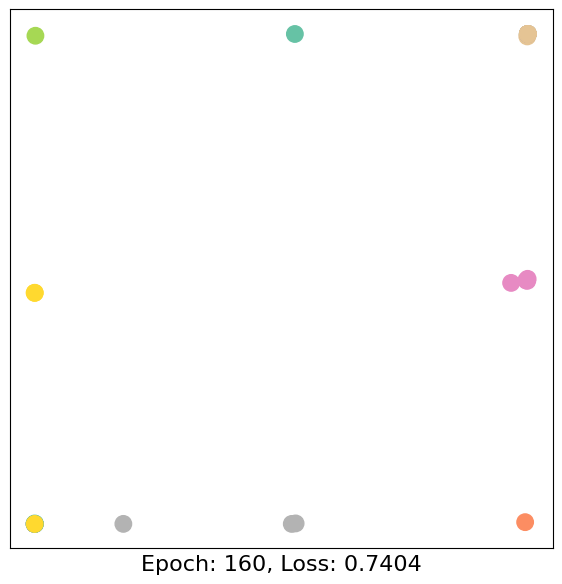

Epoch: 170, Loss: 0.7398, Accuracy: 0.7000


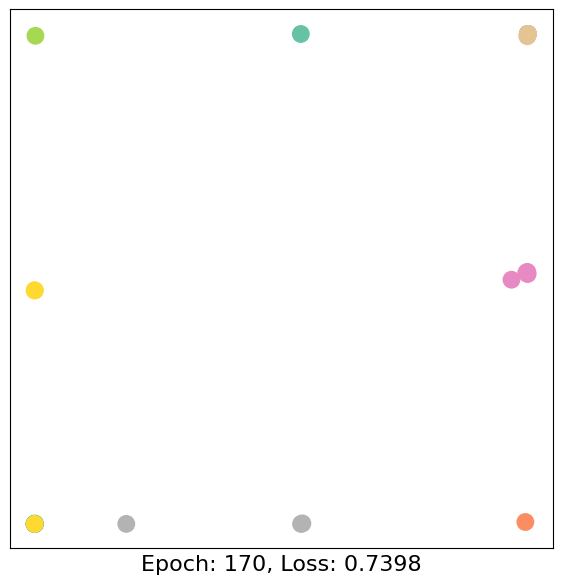

Epoch: 180, Loss: 0.7394, Accuracy: 0.7000


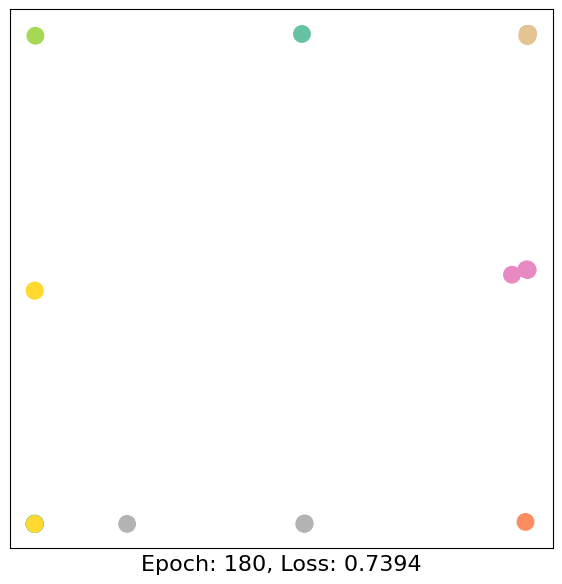

Epoch: 190, Loss: 0.7389, Accuracy: 0.7000


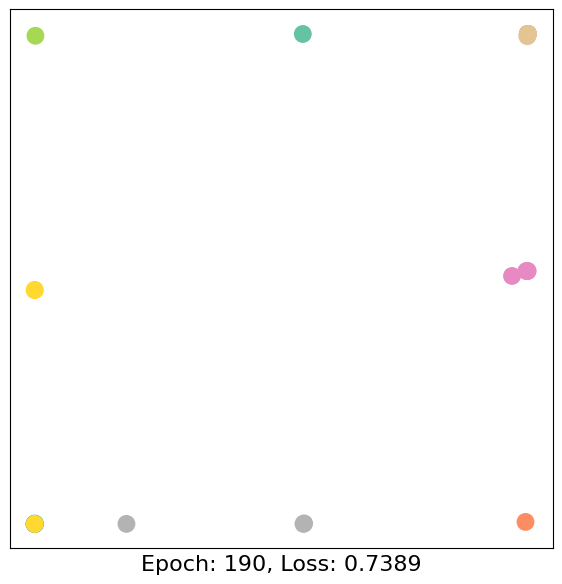

Epoch: 200, Loss: 0.7385, Accuracy: 0.7000


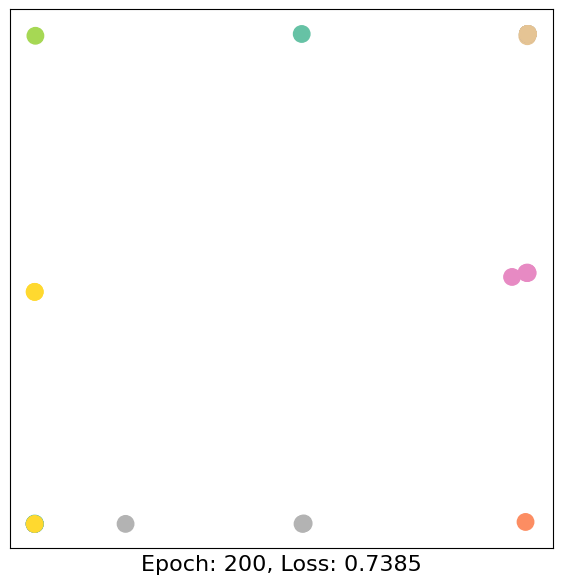

Epoch: 210, Loss: 0.7381, Accuracy: 0.7000


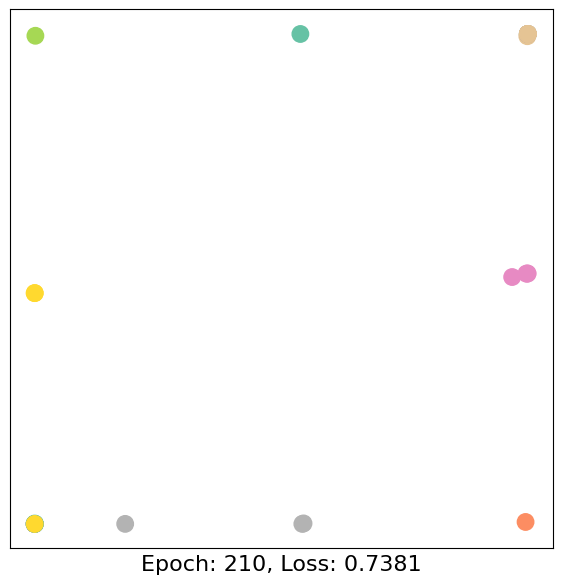

Epoch: 220, Loss: 0.7377, Accuracy: 0.7000


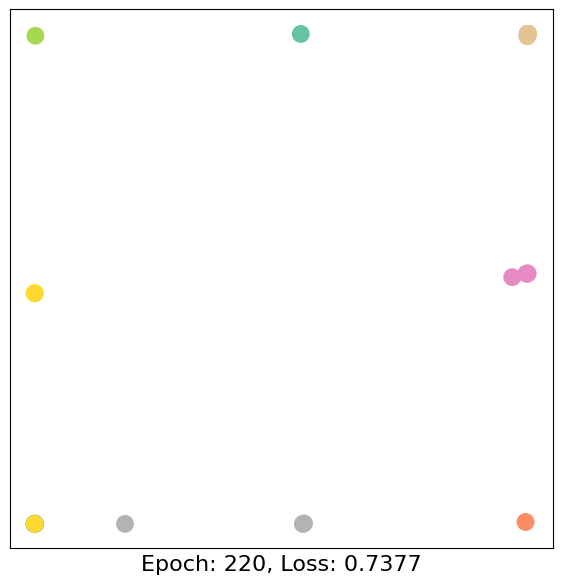

Epoch: 230, Loss: 0.7373, Accuracy: 0.7000


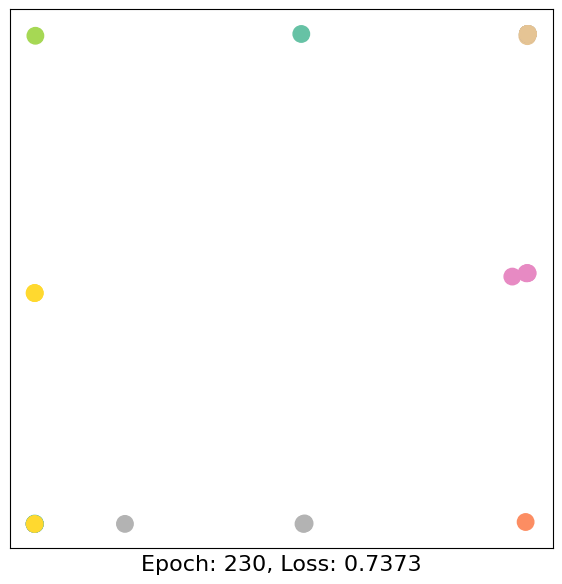

Epoch: 240, Loss: 0.7369, Accuracy: 0.7000


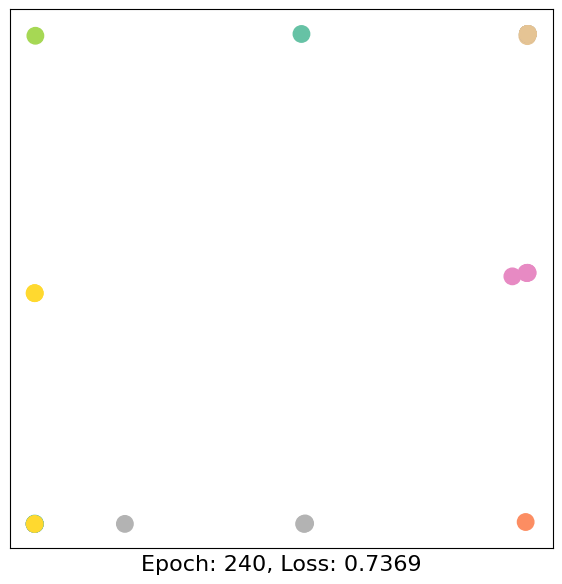

Epoch: 250, Loss: 0.7366, Accuracy: 0.7000


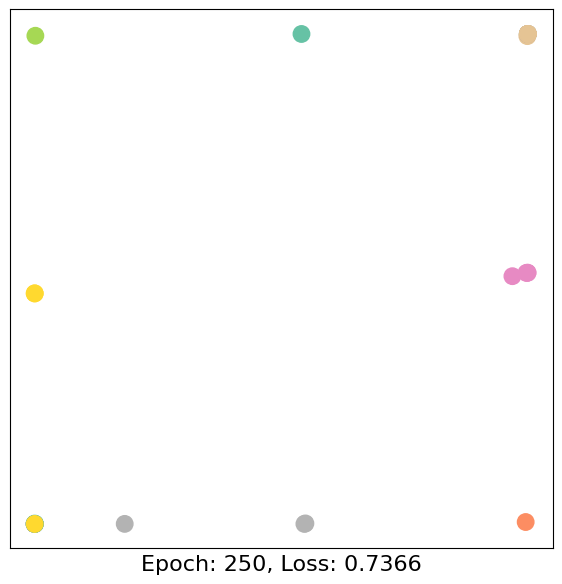

Epoch: 260, Loss: 0.7362, Accuracy: 0.7000


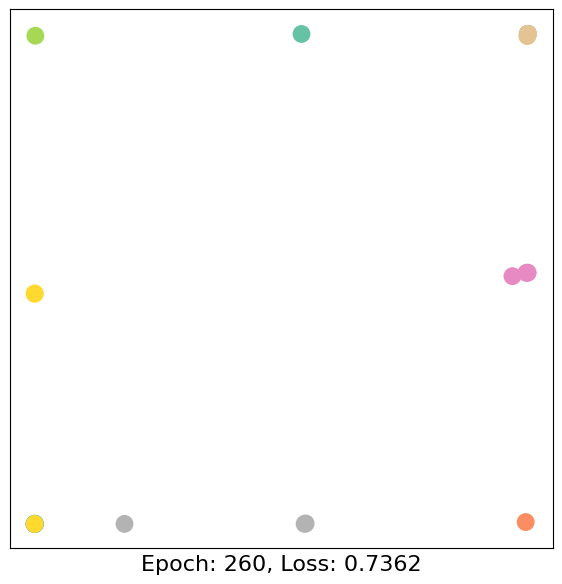

Epoch: 270, Loss: 0.7358, Accuracy: 0.7000


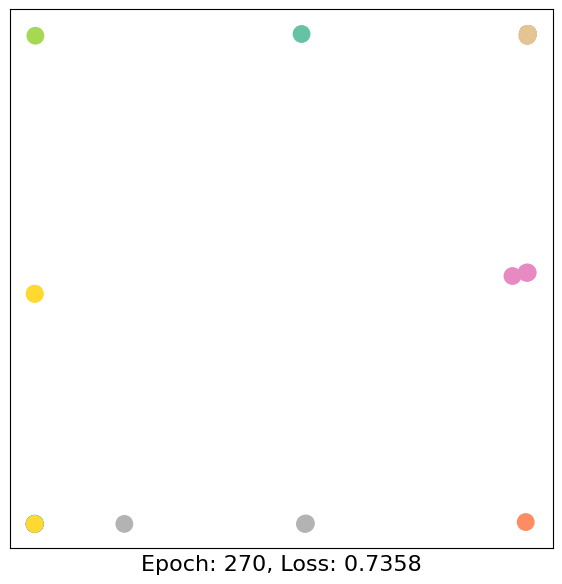

Epoch: 280, Loss: 0.7355, Accuracy: 0.7000


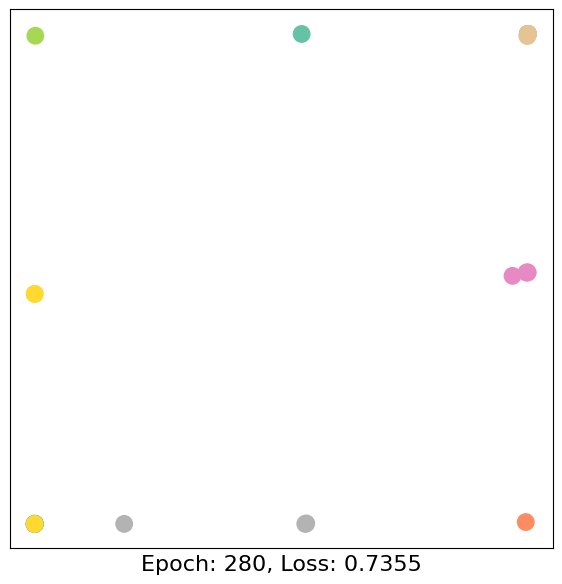

Epoch: 290, Loss: 0.7351, Accuracy: 0.7000


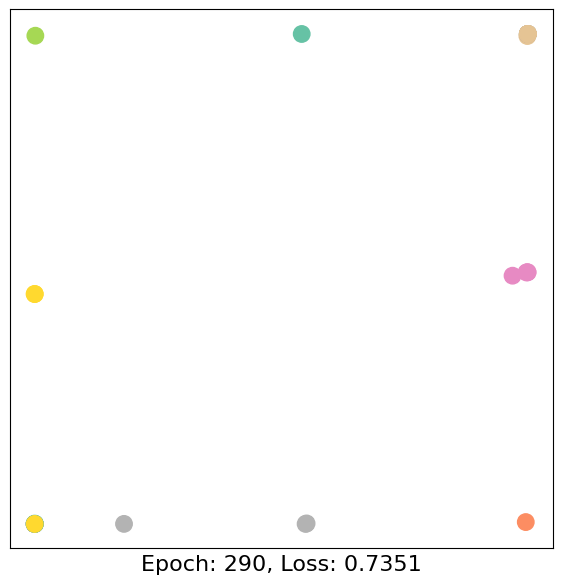

Epoch: 300, Loss: 0.7348, Accuracy: 0.7000


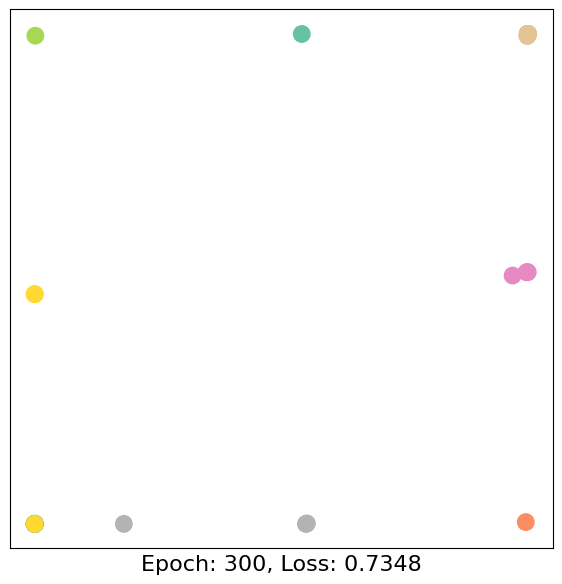

Epoch: 310, Loss: 0.7344, Accuracy: 0.7000


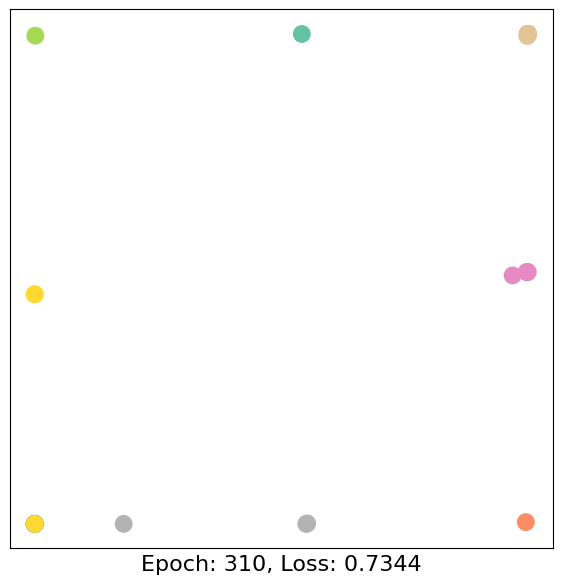

Epoch: 320, Loss: 0.7341, Accuracy: 0.7000


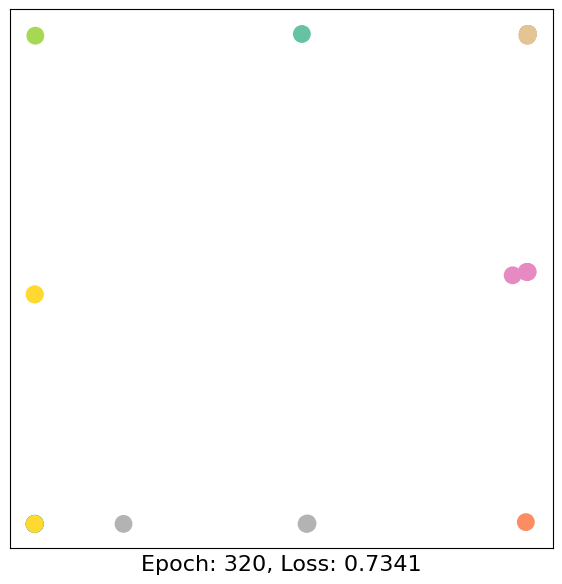

Epoch: 330, Loss: 0.7338, Accuracy: 0.7000


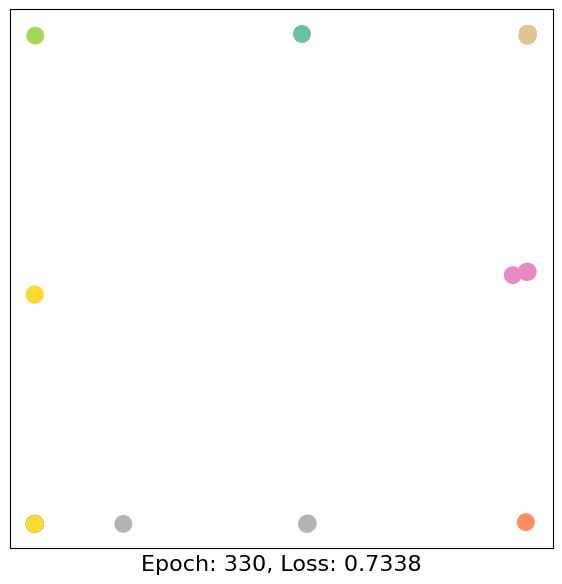

Epoch: 340, Loss: 0.7335, Accuracy: 0.7000


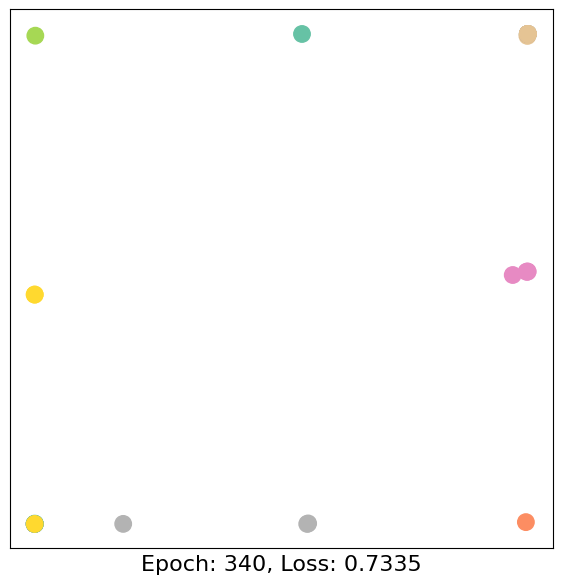

Epoch: 350, Loss: 0.7331, Accuracy: 0.7000


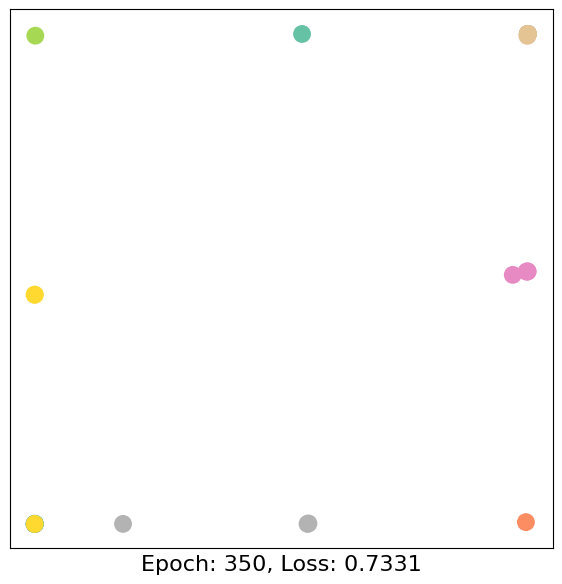

Epoch: 360, Loss: 0.7328, Accuracy: 0.7000


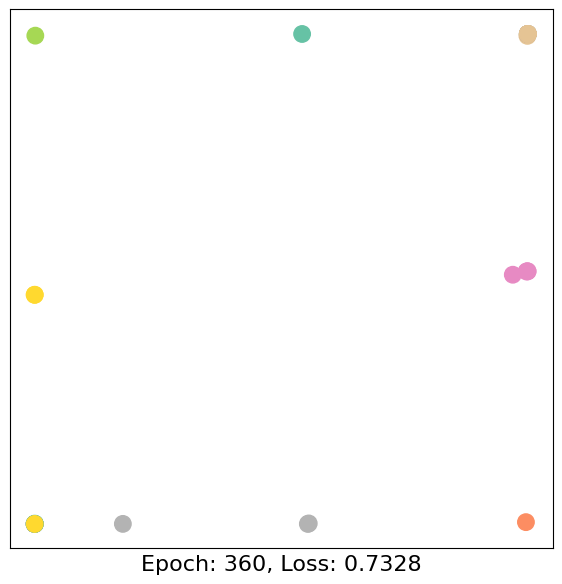

Epoch: 370, Loss: 0.7325, Accuracy: 0.7000


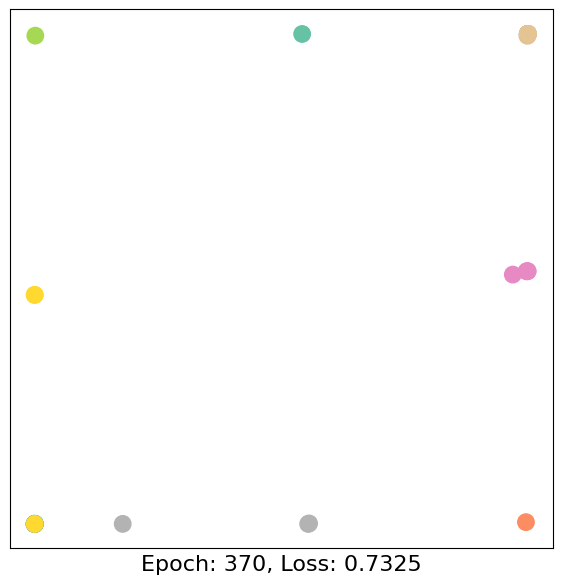

Epoch: 380, Loss: 0.7322, Accuracy: 0.7000


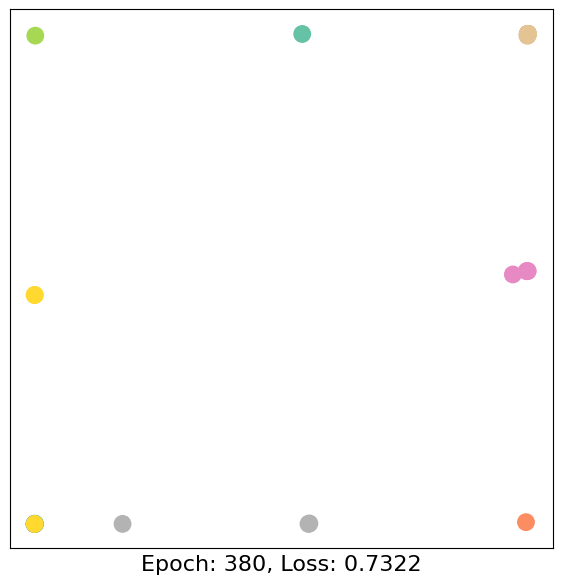

Epoch: 390, Loss: 0.7319, Accuracy: 0.7000


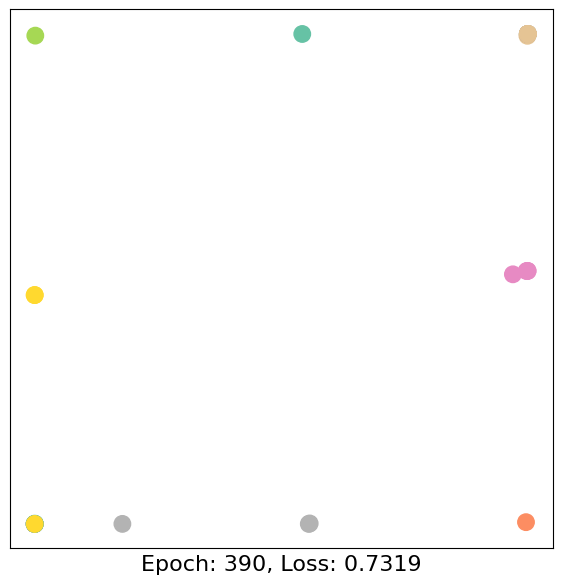

Epoch: 400, Loss: 0.7316, Accuracy: 0.7000


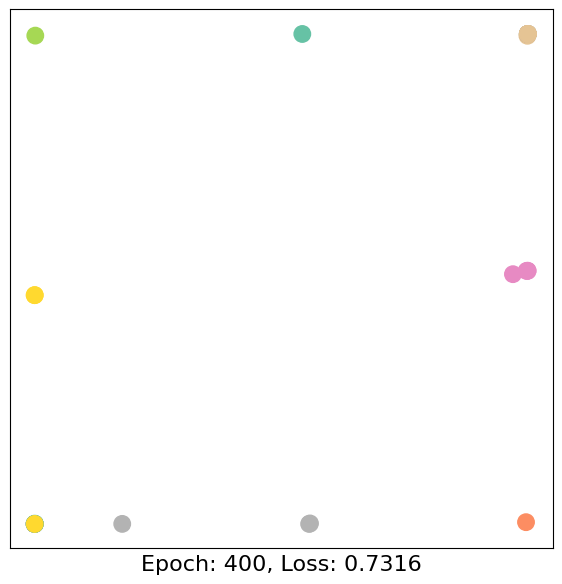

Final Accuracy: 0.7000


In [64]:
# Training loop
# Training loop
for epoch in range(401):
    loss, h, out = train(data)
    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        acc = accuracy(pred, data.y)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

# Compute final accuracy
pred = out.argmax(dim=1)
acc = accuracy(pred, data.y)
print(f'Final Accuracy: {acc:.4f}')

# Display Clusters

In [65]:
# Group and print node values by clusters
clusters = {}
for idx, cluster in enumerate(pred.tolist()):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(idx)

for cluster, nodes in clusters.items():
    print(f'Cluster {cluster}:')
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        node_value = h[node].detach().cpu().numpy()
        print(f'  Node {node_id}: {node_value}')

Cluster 7:
  Node Albert Einstein: [0.99999726 1.        ]
  Node Theory Of Relativity: [0.9999998 1.       ]
  Node E=Mc²: [0.9999998 1.       ]
  Node Apple Inc.: [0.9983416  0.99254704]
  Node Malala Yousafzai: [0.99999386 1.        ]
  Node Education Activism: [0.9999995 1.       ]
  Node I Am Malala: [0.9999996 1.       ]
  Node Malala Fund: [0.9999996 1.       ]
  Node Oprah Winfrey: [0.9999996 1.       ]
  Node The Oprah Winfrey Show: [1. 1.]
Cluster 1:
  Node Marie Curie: [-0.9999981 -1.       ]
  Node Radioactivity: [-0.99999994 -1.        ]
  Node Nobel Prize: [-0.9999998 -1.       ]
  Node Martin Luther King Jr.: [-0.9988865 -0.99996  ]
  Node Nonviolent Resistance: [-0.99999154 -0.99999994]
  Node Nelson Mandela: [-0.99999994 -0.9988254 ]
  Node Frida Kahlo: [-0.9999997 -1.       ]
  Node Self-Portraits: [-1. -1.]
Cluster 4:
  Node I Have A Dream: [0.93957525 0.01945132]
  Node Mahatma Gandhi: [0.9993914  0.03331061]
  Node Macintosh: [0.99836093 0.03339051]
  Node Iphone: 

# Remove Clusters that only have 1 node

In [66]:
# Remove clusters with only one node
clusters = {cluster: nodes for cluster, nodes in clusters.items() if len(nodes) > 1}

# Print the remaining clusters and nodes
for cluster, nodes in clusters.items():
    print(f'Cluster {cluster}:')
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        node_value = h[node].detach().cpu().numpy()
        print(f'  Node {node_id}: {node_value}')

Cluster 7:
  Node Albert Einstein: [0.99999726 1.        ]
  Node Theory Of Relativity: [0.9999998 1.       ]
  Node E=Mc²: [0.9999998 1.       ]
  Node Apple Inc.: [0.9983416  0.99254704]
  Node Malala Yousafzai: [0.99999386 1.        ]
  Node Education Activism: [0.9999995 1.       ]
  Node I Am Malala: [0.9999996 1.       ]
  Node Malala Fund: [0.9999996 1.       ]
  Node Oprah Winfrey: [0.9999996 1.       ]
  Node The Oprah Winfrey Show: [1. 1.]
Cluster 1:
  Node Marie Curie: [-0.9999981 -1.       ]
  Node Radioactivity: [-0.99999994 -1.        ]
  Node Nobel Prize: [-0.9999998 -1.       ]
  Node Martin Luther King Jr.: [-0.9988865 -0.99996  ]
  Node Nonviolent Resistance: [-0.99999154 -0.99999994]
  Node Nelson Mandela: [-0.99999994 -0.9988254 ]
  Node Frida Kahlo: [-0.9999997 -1.       ]
  Node Self-Portraits: [-1. -1.]
Cluster 4:
  Node I Have A Dream: [0.93957525 0.01945132]
  Node Mahatma Gandhi: [0.9993914  0.03331061]
  Node Macintosh: [0.99836093 0.03339051]
  Node Iphone: 